In [1]:
import sys

import argparse
from argparse import Namespace
import ast
import copy
import warnings
from typing import List

import sys
sys.path.insert(0, "../src")
import numpy as np
import torch
import traceback
from calibration_schemes.AbstractCalibration import Calibration
from calibration_schemes.CQRCalibration import CQRCalibration
from calibration_schemes.WeightedCalibration import WeightedCalibration
from calibration_schemes.PrivilegedConformalPrediction import PrivilegedConformalPrediction
from calibration_schemes.TwoStagedConformalPrediction import ConservativeWeightedCalibration
from calibration_schemes.DummyCalibration import DummyCalibration
from data_utils.data_corruption.data_corruption_masker import DataCorruptionMasker
from data_utils.data_type import DataType
from data_utils.datasets.dataset import Dataset
from data_utils.get_dataset_utils import get_regression_dataset, get_z_dim_from_data_name
from get_model_utils import get_proxy_qr_model, get_data_learning_mask_estimator, is_data_for_xgboost
from models.data_mask_estimators.OracleDataMasker import OracleDataMasker
from models.qr_models.PredictionIntervalModel import PredictionIntervalModel
from models.qr_models.QuantileRegression import QuantileRegression
from models.data_mask_estimators.DataMaskEstimator import DataMaskEstimator
from models.data_mask_estimators.NetworkMaskEstimator import NetworkMaskEstimator, XGBoostMaskEstimator
from models.qr_models.XGBoostQR import XGBoostQR
from models.regressors.regressor_factory import RegressorType, RegressorFactory
from results_helper.regression_results_helper import RegressionResultsHelper
from utils import set_seeds
import matplotlib
from sys import platform


%load_ext autoreload
%autoreload 2

## Define model parameters


In [2]:
device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'

args = Namespace(data_type="real", x_dim=15, dataset_name="missing_y_bio", data_path='../src/datasets/real_data',
                 non_linearity="lrelu", dropout=0.1, data_size=30000, hidden_dims=[32, 64, 64, 32], seed=0,
                 alpha=0.1, bs=128, wait=200, lr=1e-4, wd=0., base_results_save_dir="./results",
                 training_ratio=0.5, validation_ratio=0.1, calibration_ratio=0.2, epochs=100, figures_dir="./figures",
                 saved_models_path="./saved_models", batch_norm=False,
                 device=device_name)
args.data_type = DataType.Real if args.data_type.lower() == 'real' else DataType.Synthetic


args.z_dim = get_z_dim_from_data_name(args.dataset_name)
print(f"starting seed: {args.seed} data: {args.dataset_name}")
set_seeds(args.seed)


starting seed: 0 data: missing_y_bio


In [3]:
dataset = get_regression_dataset(args)
set_seeds(args.seed)

if 'facebook' in dataset.dataset_name:
    args.hidden_dims = [64, 128, 64, 32]
else:
    args.hidden_dims = [32, 64, 64, 32]


data size: 45730, x_dim: 8, y_dim: 1 z_dim: 1


nn model fit:   0%|          | 0/100 [00:00<?, ?it/s]

staring fit of model qr on data missing_y_bio for 100 epochs with bs=128


nn model fit: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


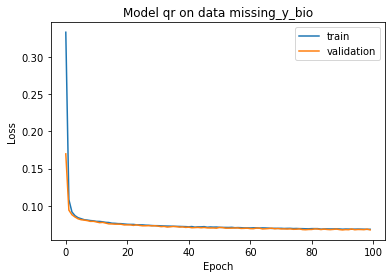

In [4]:
alpha = args.alpha
model = QuantileRegression(dataset.dataset_name, args.saved_models_path, dataset.x_dim, dataset.y_dim, alpha,
                                   hidden_dims=args.hidden_dims, dropout=args.dropout, lr=args.lr, wd=args.wd,
                                   device=args.device, figures_dir=args.figures_dir, seed=args.seed)
model.fit(dataset.x_train, dataset.y_train, dataset.deleted_train, dataset.x_val, dataset.y_val,
          dataset.deleted_val, args.epochs, args.bs, args.wait)
model.eval()

In [5]:
train_uncalibrated_intervals = model.construct_uncalibrated_intervals(dataset.x_train)
val_uncalibrated_intervals = model.construct_uncalibrated_intervals(dataset.x_val)
cal_uncalibrated_intervals = model.construct_uncalibrated_intervals(dataset.x_cal)
test_uncalibrated_intervals = model.construct_uncalibrated_intervals(dataset.x_test)

In [6]:
data_mask_estimator = OracleDataMasker(dataset.scaler, dataset.data_masker, dataset.dataset_name, dataset.x_dim, dataset.z_dim)
calibration_scheme = PrivilegedConformalPrediction(CQRCalibration(alpha), alpha, dataset.dataset_name, dataset.scaler, data_mask_estimator)

In [7]:
calibration_scheme.fit(dataset.x_train, dataset.y_train, dataset.z_train, dataset.deleted_train,
                       dataset.x_val,
                       dataset.y_val, dataset.z_val,
                       dataset.deleted_val, epochs=args.epochs, batch_size=args.bs, n_wait=args.wait,
                       train_uncalibrated_intervals=train_uncalibrated_intervals,
                       val_uncalibrated_intervals=val_uncalibrated_intervals)
calibration_scheme.calibrate(dataset.x_cal, dataset.y_cal, dataset.z_cal, dataset.deleted_cal,
                             cal_uncalibrated_intervals)

In [8]:
test_calibrated_intervals = calibration_scheme.construct_calibrated_uncertainty_sets(dataset.x_test,
                                                                                     test_uncalibrated_intervals,
                                                                                     z_test=dataset.z_test)
train_calibrated_intervals = calibration_scheme.construct_calibrated_uncertainty_sets(dataset.x_train,
                                                                                      train_uncalibrated_intervals,
                                                                                      z_test=dataset.z_train)

In [10]:
coverage_rate = np.round(test_calibrated_intervals.contains(dataset.full_y_test).float().mean().item()*100, 3)
lengths =  np.round((test_calibrated_intervals.intervals[..., 1] - test_calibrated_intervals.intervals[..., 0]).mean().item(), 3)

print(f"coverage rate: {coverage_rate}")
print(f"avg. length: {lengths}")



coverage rate: 90.335
avg. length: 2.499
